In [1]:
import random
import os
import re
import json
import numpy as np
import pandas as pd
import lightgbm as lgbm
from datetime import datetime
from time import gmtime, strftime
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import torch
import lightgbm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics
# from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec
# from PIL import Image
# # from PIL import ImageFile
# # ImageFile.LOAD_TRUNCATED_IMAGES = True
# from transformers import ViltProcessor, ViltModel


random_seed = 2020
random.seed(random_seed)
np.random.seed(random_seed)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## 读取所有的train数据和test数据，只考虑爬取部分的数据
train_category = json.load(open('../data/train_all_json/train_category.json', encoding="utf-8"))
train_category_pd = pd.DataFrame(train_category)

train_additional = json.load(open('../data/train_all_json/train_additional.json', encoding="utf-8"))
train_additional_pd = pd.DataFrame(train_additional)

train_tags = json.load(open('../data/train_all_json/train_text.json', encoding="utf-8"))
train_tags_pd = pd.DataFrame(train_tags)

train_temporalspatial = json.load(open('../data/train_all_json/train_temporalspatial.json', encoding="utf-8"))
train_temporalspatial_pd = pd.DataFrame(train_temporalspatial)

train_userdata = json.load(open('../data/train_all_json/train_userdata.json', encoding="utf-8"))
train_userdata_pd = pd.DataFrame(train_userdata)

train_img_pd = pd.read_csv('../data/train_all_json/train_imgfile.txt', header=None)
train_img_pd.columns = ['img']
# train_img_pd['img_file'] = train_img_pd['img'].apply(lambda x: '../data/train_img_url/' + x[6:])
train_img_pd['img_file'] = train_img_pd['img']
# Noting 治理直接用转换过的
# train_img_pd['img_file'] = train_img_pd['img'].apply(lambda x: '../data/train_img_url/' + x[30:]) ## 使用img_url里面的

train_label_pd = pd.read_csv('../data/train_all_json/train_label.txt', header=None)
train_label_pd.columns = ['label']

train_data = train_category_pd.merge(train_additional_pd, on=('Pid', 'Uid'), how='left')
train_data = train_data.merge(train_tags_pd, on=('Pid', 'Uid'), how='left')
train_data = train_data.merge(train_temporalspatial_pd, on=('Pid', 'Uid'), how='left')

train_data =  pd.concat([train_data, train_userdata_pd, train_img_pd, train_label_pd], axis=1)
print(len(train_data))
print(train_data.columns)

305613
Index(['Category', 'Concept', 'Pid', 'Uid', 'Subcategory', 'Mediastatus',
       'Pathalias', 'Ispublic', 'Alltags', 'Mediatype', 'Title', 'Postdate',
       'Longitude', 'Geoaccuracy', 'Latitude', 'photo_firstdatetaken',
       'location_description', 'photo_count', 'ispro', 'user_description',
       'canbuypro', 'timezone_timezone_id', 'photo_firstdate',
       'timezone_offset', 'img', 'img_file', 'label'],
      dtype='object')


In [5]:
test_category = json.load(open('../data/test_all_json/test_category.json', encoding="utf-8"))
test_category_pd = pd.DataFrame(test_category)

test_additional = json.load(open('../data/test_all_json/test_additional.json', encoding="utf-8"))
test_additional_pd = pd.DataFrame(test_additional)

test_tags = json.load(open('../data/test_all_json/test_text.json', encoding="utf-8"))
test_tags_pd = pd.DataFrame(test_tags)

test_temporalspatial = json.load(open('../data/test_all_json/test_temporalspatial.json', encoding="utf-8"))
test_temporalspatial_pd = pd.DataFrame(test_temporalspatial)

test_userdata = json.load(open('../data/test_all_json/test_userdata.json', encoding="utf-8"))
test_userdata_pd = pd.DataFrame(test_userdata)

test_img_pd = pd.read_csv('../data/test_all_json/test_imgfile.txt', header=None)
test_img_pd.columns = ['img']
# test_img_pd['img_file'] = test_img_pd['img']
test_img_pd['img_file'] = test_img_pd['img']

test_data = test_category_pd.merge(test_additional_pd, on=('Pid', 'Uid'), how='left') # 基于PID,UID将两个dataframe合并
test_data = test_data.merge(test_tags_pd, on=('Pid', 'Uid'), how='left')
test_data = test_data.merge(test_temporalspatial_pd, on=('Pid', 'Uid'), how='left')

test_data =  pd.concat([test_data, test_userdata_pd, test_img_pd], axis=1)
test_data['label'] = -1

print(len(test_data))
print(test_data.columns)

180581
Index(['Category', 'Concept', 'Pid', 'Uid', 'Subcategory', 'Mediastatus',
       'Pathalias', 'Ispublic', 'Alltags', 'Mediatype', 'Title', 'Postdate',
       'Longitude', 'Geoaccuracy', 'Latitude', 'photo_firstdatetaken',
       'location_description', 'photo_count', 'ispro', 'user_description',
       'canbuypro', 'timezone_timezone_id', 'photo_firstdate',
       'timezone_offset', 'img', 'img_file', 'label'],
      dtype='object')


In [6]:
train_data

,Category,Concept,Pid,Uid,Subcategory,Mediastatus,Pathalias,Ispublic,Alltags,Mediatype,...,photo_count,ispro,user_description,canbuypro,timezone_timezone_id,photo_firstdate,timezone_offset,img,img_file,label
0,Fashion,glam,775,59@N75,Fashion,ready,luisdrayton,1,rock punk transgender tranny electronicmusic e...,photo,...,6828,1,"0.0866962,-0.0752717,-0.0149407,-0.0460858,-0....",0,9,1213743830,1,train/59@N75/775.jpg,train/59@N75/775.jpg,11.18
1,Travel&Active&Sports,fifa,1075,1@N18,Soccer,ready,claudiolara,1,brazil rio brasil riodejaneiro by maria fifa m...,photo,...,32102,1,"0.14628,-0.0255633,-0.0711352,0.120531,-0.0728...",0,2,1263266743,0,train/1@N18/1075.jpg,train/1@N18/1075.jpg,15.15
2,Entertainment,cinema,4890,351@N64,Movies,ready,rizzato,1,old cinema beauty marilyn photoshop movie joke...,photo,...,276,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,11,1296417600,-3,train/351@N64/4890.jpg,train/351@N64/4890.jpg,10.99
3,Holiday&Celebrations,old,6568,6@N59,Birthday,ready,4kleuren,1,pictures old family scans brothers sister 1958...,photo,...,32102,1,"0.14628,-0.0255633,-0.0711352,0.120531,-0.0728...",0,2,1263266743,0,train/6@N59/6568.jpg,train/6@N59/6568.jpg,8.63
4,Food,thirsty,7079,1617@N40,Drinks,ready,glosackmd,1,hot sahara animal animals desert bottles drink...,photo,...,32102,1,"0.14628,-0.0255633,-0.0711352,0.120531,-0.0728...",0,2,1263266743,0,train/1617@N40/7079.jpg,train/1617@N40/7079.jpg,11.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305608,Animal,creature,1118328,62225@N20,Insects,ready,None,1,york travel sky urban sun france color tree gr...,photo,...,8301,1,"0.104426,0.0598804,-0.0149883,0.0338535,-0.007...",0,49,1277859911,12,train/62225@N20/1118328.jpg,train/62225@N20/1118328.jpg,4.00
305609,Social&People,portrait,1118334,108435@N35,Selfies,ready,matty3126,1,portrait cute animal cat furry panasonic calic...,photo,...,801,0,"0.114495,-0.0303421,-0.0893819,0.0774031,-0.08...",0,3,1398624531,-6,train/108435@N35/1118334.jpg,train/108435@N35/1118334.jpg,1.00
305610,Travel&Active&Sports,exotic,1118342,84730@N71,Cars,ready,khooxotics,1,car exotic german malaysia kualalumpur superca...,photo,...,574,0,"0.18969,-0.0675743,-0.125082,0.097416,-0.02100...",0,2,1394377573,0,train/84730@N71/1118342.jpg,train/84730@N71/1118342.jpg,2.00
305611,Whether&Season,cloud,1118344,9542@N37,Cloudy,ready,stevetaylors,1,city newzealand christchurch cloud building ca...,photo,...,7167,1,"0.142518,-0.0121231,-0.0464556,0.0887664,-0.02...",0,20,1234576422,10,train/9542@N37/1118344.jpg,train/9542@N37/1118344.jpg,6.89


In [7]:
test_data

,Category,Concept,Pid,Uid,Subcategory,Mediastatus,Pathalias,Ispublic,Alltags,Mediatype,...,photo_count,ispro,user_description,canbuypro,timezone_timezone_id,photo_firstdate,timezone_offset,img,img_file,label
0,Social&People,hugs,50731,8770@N36,Love,ready,None,1,vintage toys cool nikon peace lego free retro ...,photo,...,597,0,"0.0569067,-0.0662793,-0.0284383,0.0439338,-0.0...",0,2,1334752414,0,test/8770@N36/50731.jpg,test/8770@N36/50731.jpg,-1
1,Entertainment,imagine,96454,10082@N16,Books,ready,90250231n0510041136096,1,sky people musician paris tower john poetry ki...,photo,...,1213,1,"0.193048,-0.0759065,-0.0483726,0.0984259,-0.05...",0,10,1195185083,-5,test/10082@N16/96454.jpg,test/10082@N16/96454.jpg,-1
2,Food,hungry,172136,10082@N16,Dessert,ready,90250231n0510041136096,1,paris seine river skeleton fossil rivedroite d...,photo,...,1213,1,"0.193048,-0.0759065,-0.0483726,0.0984259,-0.05...",0,10,1195185083,-5,test/10082@N16/172136.jpg,test/10082@N16/172136.jpg,-1
3,Entertainment,bookworm,177707,24607@N38,Books,ready,jmdsnowflakes,1,reading book community library libraries maine...,photo,...,1213,1,"0.193048,-0.0759065,-0.0483726,0.0984259,-0.05...",0,10,1195185083,-5,test/24607@N38/177707.jpg,test/24607@N38/177707.jpg,-1
4,Entertainment,bookworm,177708,24607@N38,Books,ready,jmdsnowflakes,1,reading book community library libraries maine...,photo,...,1213,1,"0.193048,-0.0759065,-0.0483726,0.0984259,-0.05...",0,10,1195185083,-5,test/24607@N38/177708.jpg,test/24607@N38/177708.jpg,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180576,Travel&Active&Sports,sea,1118324,49686@N77,Seattle,ready,larsgerrits,1,natur nature frog sea lake fish outdoor macro ...,photo,...,1294,1,"0.150263,0.00344591,-0.158953,0.118596,-0.0566...",0,8,1394046082,0,test/49686@N77/1118324.jpg,test/49686@N77/1118324.jpg,-1
180577,Travel&Active&Sports,cars,1118329,31147@N75,Cars,ready,None,1,11 arisk okruh veternov 2016 10 jn preov veter...,photo,...,17,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1460319331,0,test/31147@N75/1118329.jpg,test/31147@N75/1118329.jpg,-1
180578,Animal,cat,1118336,5656@N26,Cats,ready,rogersg,1,holland netherlands amsterdam cat nl ramses gu...,photo,...,313,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,9,1464117797,1,test/5656@N26/1118336.jpg,test/5656@N26/1118336.jpg,-1
180579,Whether&Season,white,1118349,28302@N36,Snowing,ready,ripensis,1,street people bw white black netherlands monoc...,photo,...,605,1,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1246915883,0,test/28302@N36/1118349.jpg,test/28302@N36/1118349.jpg,-1


In [8]:
all_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

In [10]:
all_data

,Category,Concept,Pid,Uid,Subcategory,Mediastatus,Pathalias,Ispublic,Alltags,Mediatype,...,photo_count,ispro,user_description,canbuypro,timezone_timezone_id,photo_firstdate,timezone_offset,img,img_file,label
0,Fashion,glam,775,59@N75,Fashion,ready,luisdrayton,1,rock punk transgender tranny electronicmusic e...,photo,...,6828,1,"0.0866962,-0.0752717,-0.0149407,-0.0460858,-0....",0,9,1213743830,1,train/59@N75/775.jpg,train/59@N75/775.jpg,11.18
1,Travel&Active&Sports,fifa,1075,1@N18,Soccer,ready,claudiolara,1,brazil rio brasil riodejaneiro by maria fifa m...,photo,...,32102,1,"0.14628,-0.0255633,-0.0711352,0.120531,-0.0728...",0,2,1263266743,0,train/1@N18/1075.jpg,train/1@N18/1075.jpg,15.15
2,Entertainment,cinema,4890,351@N64,Movies,ready,rizzato,1,old cinema beauty marilyn photoshop movie joke...,photo,...,276,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,11,1296417600,-3,train/351@N64/4890.jpg,train/351@N64/4890.jpg,10.99
3,Holiday&Celebrations,old,6568,6@N59,Birthday,ready,4kleuren,1,pictures old family scans brothers sister 1958...,photo,...,32102,1,"0.14628,-0.0255633,-0.0711352,0.120531,-0.0728...",0,2,1263266743,0,train/6@N59/6568.jpg,train/6@N59/6568.jpg,8.63
4,Food,thirsty,7079,1617@N40,Drinks,ready,glosackmd,1,hot sahara animal animals desert bottles drink...,photo,...,32102,1,"0.14628,-0.0255633,-0.0711352,0.120531,-0.0728...",0,2,1263266743,0,train/1617@N40/7079.jpg,train/1617@N40/7079.jpg,11.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486189,Travel&Active&Sports,sea,1118324,49686@N77,Seattle,ready,larsgerrits,1,natur nature frog sea lake fish outdoor macro ...,photo,...,1294,1,"0.150263,0.00344591,-0.158953,0.118596,-0.0566...",0,8,1394046082,0,test/49686@N77/1118324.jpg,test/49686@N77/1118324.jpg,-1.00
486190,Travel&Active&Sports,cars,1118329,31147@N75,Cars,ready,None,1,11 arisk okruh veternov 2016 10 jn preov veter...,photo,...,17,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1460319331,0,test/31147@N75/1118329.jpg,test/31147@N75/1118329.jpg,-1.00
486191,Animal,cat,1118336,5656@N26,Cats,ready,rogersg,1,holland netherlands amsterdam cat nl ramses gu...,photo,...,313,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,9,1464117797,1,test/5656@N26/1118336.jpg,test/5656@N26/1118336.jpg,-1.00
486192,Whether&Season,white,1118349,28302@N36,Snowing,ready,ripensis,1,street people bw white black netherlands monoc...,photo,...,605,1,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1246915883,0,test/28302@N36/1118349.jpg,test/28302@N36/1118349.jpg,-1.00


In [23]:
train_data_date = train_data.sort_values(by="Postdate", ascending=True) 
train_data_date

,Category,Concept,Pid,Uid,Subcategory,Mediastatus,Pathalias,Ispublic,Alltags,Mediatype,...,photo_count,ispro,user_description,canbuypro,timezone_timezone_id,photo_firstdate,timezone_offset,img,img_file,label
7626,Fashion,crease,165243,25055@N61,Makeup,ready,judygr,1,london art history station writing mirror ungu...,photo,...,9584,1,"0.19905,-0.0412846,-0.0650649,0.114256,-0.0525...",0,59,1266564562,-10,train/25055@N61/165243.jpg,train/25055@N61/165243.jpg,7.46
236834,Animal,horseshoe,455735,52594@N92,Horses,ready,None,1,camera white black art vintage box os horsesho...,photo,...,2294,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1386081833,0,train/52594@N92/455735.jpg,train/52594@N92/455735.jpg,6.82
6823,Travel&Active&Sports,faithful,164069,24888@N45,San,ready,youreyestellies,1,portrait blackandwhite girl strange dream surr...,photo,...,5682,1,"0.160823,0.00626395,-0.0671702,-0.0835787,-0.0...",0,2,1229953933,0,train/24888@N45/164069.jpg,train/24888@N45/164069.jpg,11.98
3208,Food,thirsty,158872,24126@N55,Drinks,ready,toddjacops,1,bird thirsty,photo,...,3208,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1426154060,0,train/24126@N55/158872.jpg,train/24126@N55/158872.jpg,6.51
3983,Fashion,eyeshadow,160187,24359@N35,Makeup,ready,None,1,morning wedding portrait face bride eyes artis...,photo,...,719,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1427468308,0,train/24359@N35/160187.jpg,train/24359@N35/160187.jpg,8.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198883,Entertainment,gamer,378373,27217@N12,Video&Games,ready,emleelion,1,original leather fire one carved order nine ni...,photo,...,10797,1,"0.0688888,-0.0985226,-0.0342918,-0.0995639,0.0...",0,2,1330299932,0,train/27217@N12/378373.jpg,train/27217@N12/378373.jpg,6.11
236333,Holiday&Celebrations,scary,452871,57245@N77,Halloween,ready,None,1,me self scary blood photographer creepy horror,photo,...,651,1,"0.0769688,-0.249931,0.0396651,-0.104271,0.1290...",0,0,1242915207,1,train/57245@N77/452871.jpg,train/57245@N77/452871.jpg,4.95
225861,Travel&Active&Sports,bars,417154,35656@N48,Gymnastics,ready,recherche_accord_parfait,1,bars talent hiphop dancehall hyena facts nofea...,video,...,8215,1,"0.168312,-0.0737876,-0.11398,0.126349,-0.06150...",0,10,1216531878,-5,train/35656@N48/417154.jpg,train/35656@N48/417154.jpg,6.09
237181,Travel&Active&Sports,fitnessmodel,457770,47240@N91,"Health,Fitness",ready,dannyzak,1,summer sexy beautiful photography amazing nice...,photo,...,4169,1,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1340787602,0,train/47240@N91/457770.jpg,train/47240@N91/457770.jpg,10.63


In [35]:
train_data_date['date'] = pd.to_datetime(train_data_date['Postdate'],unit='s')
train_data_date

,Category,Concept,Pid,Uid,Subcategory,Mediastatus,Pathalias,Ispublic,Alltags,Mediatype,...,ispro,user_description,canbuypro,timezone_timezone_id,photo_firstdate,timezone_offset,img,img_file,label,date
7626,Fashion,crease,165243,25055@N61,Makeup,ready,judygr,1,london art history station writing mirror ungu...,photo,...,1,"0.19905,-0.0412846,-0.0650649,0.114256,-0.0525...",0,59,1266564562,-10,train/25055@N61/165243.jpg,train/25055@N61/165243.jpg,7.46,2015-02-28 16:00:00
236834,Animal,horseshoe,455735,52594@N92,Horses,ready,None,1,camera white black art vintage box os horsesho...,photo,...,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1386081833,0,train/52594@N92/455735.jpg,train/52594@N92/455735.jpg,6.82,2015-02-28 16:00:00
6823,Travel&Active&Sports,faithful,164069,24888@N45,San,ready,youreyestellies,1,portrait blackandwhite girl strange dream surr...,photo,...,1,"0.160823,0.00626395,-0.0671702,-0.0835787,-0.0...",0,2,1229953933,0,train/24888@N45/164069.jpg,train/24888@N45/164069.jpg,11.98,2015-02-28 16:00:00
3208,Food,thirsty,158872,24126@N55,Drinks,ready,toddjacops,1,bird thirsty,photo,...,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1426154060,0,train/24126@N55/158872.jpg,train/24126@N55/158872.jpg,6.51,2015-02-28 16:00:00
3983,Fashion,eyeshadow,160187,24359@N35,Makeup,ready,None,1,morning wedding portrait face bride eyes artis...,photo,...,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1427468308,0,train/24359@N35/160187.jpg,train/24359@N35/160187.jpg,8.14,2015-02-28 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198883,Entertainment,gamer,378373,27217@N12,Video&Games,ready,emleelion,1,original leather fire one carved order nine ni...,photo,...,1,"0.0688888,-0.0985226,-0.0342918,-0.0995639,0.0...",0,2,1330299932,0,train/27217@N12/378373.jpg,train/27217@N12/378373.jpg,6.11,2016-02-29 15:46:06
236333,Holiday&Celebrations,scary,452871,57245@N77,Halloween,ready,None,1,me self scary blood photographer creepy horror,photo,...,1,"0.0769688,-0.249931,0.0396651,-0.104271,0.1290...",0,0,1242915207,1,train/57245@N77/452871.jpg,train/57245@N77/452871.jpg,4.95,2016-02-29 15:48:47
225861,Travel&Active&Sports,bars,417154,35656@N48,Gymnastics,ready,recherche_accord_parfait,1,bars talent hiphop dancehall hyena facts nofea...,video,...,1,"0.168312,-0.0737876,-0.11398,0.126349,-0.06150...",0,10,1216531878,-5,train/35656@N48/417154.jpg,train/35656@N48/417154.jpg,6.09,2016-02-29 15:48:59
237181,Travel&Active&Sports,fitnessmodel,457770,47240@N91,"Health,Fitness",ready,dannyzak,1,summer sexy beautiful photography amazing nice...,photo,...,1,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1340787602,0,train/47240@N91/457770.jpg,train/47240@N91/457770.jpg,10.63,2016-02-29 15:54:13


In [ ]:
train_data_date

In [41]:
import datetime
train_data_date['datetime'] = train_data_date['Postdate'].apply(lambda x: str(datetime.datetime.fromtimestamp(int(x)).year) + str(datetime.datetime.fromtimestamp(int(x)).month)+str(datetime.datetime.fromtimestamp(int(x)).day))

In [42]:
train_data_date

,Category,Concept,Pid,Uid,Subcategory,Mediastatus,Pathalias,Ispublic,Alltags,Mediatype,...,user_description,canbuypro,timezone_timezone_id,photo_firstdate,timezone_offset,img,img_file,label,date,datetime
7626,Fashion,crease,165243,25055@N61,Makeup,ready,judygr,1,london art history station writing mirror ungu...,photo,...,"0.19905,-0.0412846,-0.0650649,0.114256,-0.0525...",0,59,1266564562,-10,train/25055@N61/165243.jpg,train/25055@N61/165243.jpg,7.46,2015-02-28 16:00:00,201531
236834,Animal,horseshoe,455735,52594@N92,Horses,ready,None,1,camera white black art vintage box os horsesho...,photo,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1386081833,0,train/52594@N92/455735.jpg,train/52594@N92/455735.jpg,6.82,2015-02-28 16:00:00,201531
6823,Travel&Active&Sports,faithful,164069,24888@N45,San,ready,youreyestellies,1,portrait blackandwhite girl strange dream surr...,photo,...,"0.160823,0.00626395,-0.0671702,-0.0835787,-0.0...",0,2,1229953933,0,train/24888@N45/164069.jpg,train/24888@N45/164069.jpg,11.98,2015-02-28 16:00:00,201531
3208,Food,thirsty,158872,24126@N55,Drinks,ready,toddjacops,1,bird thirsty,photo,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1426154060,0,train/24126@N55/158872.jpg,train/24126@N55/158872.jpg,6.51,2015-02-28 16:00:00,201531
3983,Fashion,eyeshadow,160187,24359@N35,Makeup,ready,None,1,morning wedding portrait face bride eyes artis...,photo,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1427468308,0,train/24359@N35/160187.jpg,train/24359@N35/160187.jpg,8.14,2015-02-28 16:00:00,201531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198883,Entertainment,gamer,378373,27217@N12,Video&Games,ready,emleelion,1,original leather fire one carved order nine ni...,photo,...,"0.0688888,-0.0985226,-0.0342918,-0.0995639,0.0...",0,2,1330299932,0,train/27217@N12/378373.jpg,train/27217@N12/378373.jpg,6.11,2016-02-29 15:46:06,2016229
236333,Holiday&Celebrations,scary,452871,57245@N77,Halloween,ready,None,1,me self scary blood photographer creepy horror,photo,...,"0.0769688,-0.249931,0.0396651,-0.104271,0.1290...",0,0,1242915207,1,train/57245@N77/452871.jpg,train/57245@N77/452871.jpg,4.95,2016-02-29 15:48:47,2016229
225861,Travel&Active&Sports,bars,417154,35656@N48,Gymnastics,ready,recherche_accord_parfait,1,bars talent hiphop dancehall hyena facts nofea...,video,...,"0.168312,-0.0737876,-0.11398,0.126349,-0.06150...",0,10,1216531878,-5,train/35656@N48/417154.jpg,train/35656@N48/417154.jpg,6.09,2016-02-29 15:48:59,2016229
237181,Travel&Active&Sports,fitnessmodel,457770,47240@N91,"Health,Fitness",ready,dannyzak,1,summer sexy beautiful photography amazing nice...,photo,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1340787602,0,train/47240@N91/457770.jpg,train/47240@N91/457770.jpg,10.63,2016-02-29 15:54:13,2016229


In [56]:
train_data_date.loc[train_data_date['label']< 5.12]

,Category,Concept,Pid,Uid,Subcategory,Mediastatus,Pathalias,Ispublic,Alltags,Mediatype,...,user_description,canbuypro,timezone_timezone_id,photo_firstdate,timezone_offset,img,img_file,label,date,datetime
278583,Entertainment,melody,796371,70051@N44,Music,ready,None,1,melody jkt48,photo,...,"0.198202,-0.00571578,-0.15296,0.0761933,0.0392...",0,5,1404613736,-8,train/70051@N44/796371.jpg,train/70051@N44/796371.jpg,3.46,2015-02-28 16:02:43,201531
237612,Entertainment,beat,459981,51883@N2,Music,ready,None,1,girls party music girl japan club disco effect...,photo,...,"-0.107992,-0.158196,0.0517032,0.250465,0.05226...",0,4,1297710965,2,train/51883@N2/459981.jpg,train/51883@N2/459981.jpg,4.52,2015-02-28 19:03:19,201531
280076,Fashion,makeup,811840,90493@N40,Makeup,ready,None,1,shoot vsco fashion model moda colombia makeup ...,photo,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0,1406631292,1,train/90493@N40/811840.jpg,train/90493@N40/811840.jpg,4.25,2015-02-28 19:30:50,201531
234765,Entertainment,beat,446546,51883@N2,Music,ready,None,1,girls party music girl japan club disco effect...,photo,...,"0.114765,-0.00639922,-0.0868175,0.0918194,-0.0...",0,5,1271373769,-8,train/51883@N2/446546.jpg,train/51883@N2/446546.jpg,4.52,2015-02-28 19:34:46,201531
3501,Entertainment,newsong,159437,24228@N18,Music,ready,None,1,rap folie newsong frenchhiphop lecommencedelag...,photo,...,"-0.0290175,0.141248,-0.224895,0.156581,-0.0250...",0,15,1424598680,5,train/24228@N18/159437.jpg,train/24228@N18/159437.jpg,2.81,2015-03-01 00:12:42,201531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247432,Whether&Season,frosty,522808,53822@N8,Snowing,ready,None,1,blue trees winter white lake snow cold ice fro...,photo,...,"0.167748,-0.0510766,-0.0607302,0.0814971,-0.07...",0,8,1223148353,0,train/53822@N8/522808.jpg,train/53822@N8/522808.jpg,4.95,2016-02-29 14:42:22,2016229
260701,Fashion,lip,634695,78391@N95,Makeup,ready,None,1,red sexy girl beautiful nice lip greyhair inred,photo,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,5,1461981216,-8,train/78391@N95/634695.jpg,train/78391@N95/634695.jpg,4.58,2016-02-29 14:56:14,2016229
225122,Fashion,accessory,415165,40437@N38,Jewelry,ready,bijouxreplique,1,jewellery accessory pinterest,photo,...,"-0.00289774,-0.112958,-0.00142759,-0.0735336,0...",0,11,1457275864,-3,train/40437@N38/415165.jpg,train/40437@N38/415165.jpg,4.75,2016-02-29 15:06:39,2016229
213186,Travel&Active&Sports,diet,396720,43917@N64,"Health,Fitness",ready,None,1,diet fitness weightloss nutrition fatlosstips ...,photo,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0,1424717088,1,train/43917@N64/396720.jpg,train/43917@N64/396720.jpg,5.09,2016-02-29 15:37:44,2016229


In [57]:
train_data_date.loc[train_data_date['label']< 6]

,Category,Concept,Pid,Uid,Subcategory,Mediastatus,Pathalias,Ispublic,Alltags,Mediatype,...,user_description,canbuypro,timezone_timezone_id,photo_firstdate,timezone_offset,img,img_file,label,date,datetime
278583,Entertainment,melody,796371,70051@N44,Music,ready,None,1,melody jkt48,photo,...,"0.198202,-0.00571578,-0.15296,0.0761933,0.0392...",0,5,1404613736,-8,train/70051@N44/796371.jpg,train/70051@N44/796371.jpg,3.46,2015-02-28 16:02:43,201531
609,Holiday&Celebrations,thankful,146385,21369@N1,Thanksgiving,ready,None,1,new morning school our 2 3 love ???? night fun...,photo,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1216238439,0,train/21369@N1/146385.jpg,train/21369@N1/146385.jpg,5.43,2015-02-28 17:40:57,201531
237612,Entertainment,beat,459981,51883@N2,Music,ready,None,1,girls party music girl japan club disco effect...,photo,...,"-0.107992,-0.158196,0.0517032,0.250465,0.05226...",0,4,1297710965,2,train/51883@N2/459981.jpg,train/51883@N2/459981.jpg,4.52,2015-02-28 19:03:19,201531
1902,Fashion,cosmetic,155458,22236@N63,Makeup,ready,balajiksamy,1,music fashion bike sport photography furniture...,photo,...,"0.341866,-0.183735,-0.13053,0.109917,0.198439,...",0,2,1201198711,0,train/22236@N63/155458.jpg,train/22236@N63/155458.jpg,5.13,2015-02-28 19:15:32,201531
280076,Fashion,makeup,811840,90493@N40,Makeup,ready,None,1,shoot vsco fashion model moda colombia makeup ...,photo,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0,1406631292,1,train/90493@N40/811840.jpg,train/90493@N40/811840.jpg,4.25,2015-02-28 19:30:50,201531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225860,Travel&Active&Sports,bars,417153,35656@N48,Gymnastics,ready,recherche_accord_parfait,1,bars talent hiphop dancehall hyena facts nofea...,photo,...,"0.168312,-0.0737876,-0.11398,0.126349,-0.06150...",0,10,1216531878,-5,train/35656@N48/417153.jpg,train/35656@N48/417153.jpg,5.43,2016-02-29 15:29:28,2016229
199487,Travel&Active&Sports,bars,379053,35656@N48,Gymnastics,ready,recherche_accord_parfait,1,bars talent hiphop dancehall hyena facts nofea...,photo,...,"-0.0935028,0.0936458,0.0159591,-0.0927738,-0.0...",0,5,1287799077,-8,train/35656@N48/379053.jpg,train/35656@N48/379053.jpg,5.52,2016-02-29 15:34:45,2016229
213186,Travel&Active&Sports,diet,396720,43917@N64,"Health,Fitness",ready,None,1,diet fitness weightloss nutrition fatlosstips ...,photo,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0,1424717088,1,train/43917@N64/396720.jpg,train/43917@N64/396720.jpg,5.09,2016-02-29 15:37:44,2016229
228149,Travel&Active&Sports,leap,422590,53662@N42,Gymnastics,ready,ewian,1,art girl illustration ink faith used watercolo...,photo,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1296020359,0,train/53662@N42/422590.jpg,train/53662@N42/422590.jpg,5.81,2016-02-29 15:40:37,2016229


In [80]:
index_755 = train_data_date.loc[train_data_date['label']< 7.55].index.to_list()

In [87]:
# 

In [88]:
pd.DataFrame(sorted(index_755)).to_csv('../data/train_all_json/index_755.txt')

In [103]:
df_755 = pd.read_csv('../data/train_all_json/index_755.txt', index_col = 0)
# list(df_755['0'])

In [105]:
train_data.iloc[list(df_755['0'])]

,Category,Concept,Pid,Uid,Subcategory,Mediastatus,Pathalias,Ispublic,Alltags,Mediatype,...,photo_count,ispro,user_description,canbuypro,timezone_timezone_id,photo_firstdate,timezone_offset,img,img_file,label
9,Entertainment,dubstep,14573,69@N28,Music,ready,the_hookups,1,riodejaneiro centro shoreditch techno vans dub...,photo,...,240,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1362080077,0,train/69@N28/14573.jpg,train/69@N28/14573.jpg,6.51
10,Holiday&Celebrations,funtimes,15253,2905@N47,Party,ready,handosnapdada,1,funtimes,photo,...,117,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,10,1306596712,-5,train/2905@N47/15253.jpg,train/2905@N47/15253.jpg,5.00
116,Entertainment,rnb,30916,3175@N73,Music,ready,djmonalisa,1,music newyork celebrity brooklyn radio flickr ...,photo,...,1965,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,49,1408052094,12,train/3175@N73/30916.jpg,train/3175@N73/30916.jpg,3.70
160,Whether&Season,falltime,56950,7068@N95,Fall,ready,None,1,city pink red sky urban canada flower color re...,photo,...,9753,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1421922980,0,train/7068@N95/56950.jpg,train/7068@N95/56950.jpg,7.33
166,Entertainment,newsong,59435,9857@N75,Music,ready,tatianasantosmg,1,show party brazil music love rock banda casa d...,photo,...,857,0,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,5,1394611500,-8,train/9857@N75/59435.jpg,train/9857@N75/59435.jpg,5.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305608,Animal,creature,1118328,62225@N20,Insects,ready,None,1,york travel sky urban sun france color tree gr...,photo,...,8301,1,"0.104426,0.0598804,-0.0149883,0.0338535,-0.007...",0,49,1277859911,12,train/62225@N20/1118328.jpg,train/62225@N20/1118328.jpg,4.00
305609,Social&People,portrait,1118334,108435@N35,Selfies,ready,matty3126,1,portrait cute animal cat furry panasonic calic...,photo,...,801,0,"0.114495,-0.0303421,-0.0893819,0.0774031,-0.08...",0,3,1398624531,-6,train/108435@N35/1118334.jpg,train/108435@N35/1118334.jpg,1.00
305610,Travel&Active&Sports,exotic,1118342,84730@N71,Cars,ready,khooxotics,1,car exotic german malaysia kualalumpur superca...,photo,...,574,0,"0.18969,-0.0675743,-0.125082,0.097416,-0.02100...",0,2,1394377573,0,train/84730@N71/1118342.jpg,train/84730@N71/1118342.jpg,2.00
305611,Whether&Season,cloud,1118344,9542@N37,Cloudy,ready,stevetaylors,1,city newzealand christchurch cloud building ca...,photo,...,7167,1,"0.142518,-0.0121231,-0.0464556,0.0887664,-0.02...",0,20,1234576422,10,train/9542@N37/1118344.jpg,train/9542@N37/1118344.jpg,6.89


In [74]:
np.mean(train_data_date.loc[train_data_date['label']< 7.55]['label'])

5.120393384691497

In [75]:
np.std(train_data_date.loc[train_data_date['label']< 7.55]['label'])

1.55370051100773

In [43]:
reindexed_train_data_date = train_data_date.reset_index()
reindexed_train_data_date

,index,Category,Concept,Pid,Uid,Subcategory,Mediastatus,Pathalias,Ispublic,Alltags,...,user_description,canbuypro,timezone_timezone_id,photo_firstdate,timezone_offset,img,img_file,label,date,datetime
0,7626,Fashion,crease,165243,25055@N61,Makeup,ready,judygr,1,london art history station writing mirror ungu...,...,"0.19905,-0.0412846,-0.0650649,0.114256,-0.0525...",0,59,1266564562,-10,train/25055@N61/165243.jpg,train/25055@N61/165243.jpg,7.46,2015-02-28 16:00:00,201531
1,236834,Animal,horseshoe,455735,52594@N92,Horses,ready,None,1,camera white black art vintage box os horsesho...,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1386081833,0,train/52594@N92/455735.jpg,train/52594@N92/455735.jpg,6.82,2015-02-28 16:00:00,201531
2,6823,Travel&Active&Sports,faithful,164069,24888@N45,San,ready,youreyestellies,1,portrait blackandwhite girl strange dream surr...,...,"0.160823,0.00626395,-0.0671702,-0.0835787,-0.0...",0,2,1229953933,0,train/24888@N45/164069.jpg,train/24888@N45/164069.jpg,11.98,2015-02-28 16:00:00,201531
3,3208,Food,thirsty,158872,24126@N55,Drinks,ready,toddjacops,1,bird thirsty,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1426154060,0,train/24126@N55/158872.jpg,train/24126@N55/158872.jpg,6.51,2015-02-28 16:00:00,201531
4,3983,Fashion,eyeshadow,160187,24359@N35,Makeup,ready,None,1,morning wedding portrait face bride eyes artis...,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1427468308,0,train/24359@N35/160187.jpg,train/24359@N35/160187.jpg,8.14,2015-02-28 16:00:00,201531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305608,198883,Entertainment,gamer,378373,27217@N12,Video&Games,ready,emleelion,1,original leather fire one carved order nine ni...,...,"0.0688888,-0.0985226,-0.0342918,-0.0995639,0.0...",0,2,1330299932,0,train/27217@N12/378373.jpg,train/27217@N12/378373.jpg,6.11,2016-02-29 15:46:06,2016229
305609,236333,Holiday&Celebrations,scary,452871,57245@N77,Halloween,ready,None,1,me self scary blood photographer creepy horror,...,"0.0769688,-0.249931,0.0396651,-0.104271,0.1290...",0,0,1242915207,1,train/57245@N77/452871.jpg,train/57245@N77/452871.jpg,4.95,2016-02-29 15:48:47,2016229
305610,225861,Travel&Active&Sports,bars,417154,35656@N48,Gymnastics,ready,recherche_accord_parfait,1,bars talent hiphop dancehall hyena facts nofea...,...,"0.168312,-0.0737876,-0.11398,0.126349,-0.06150...",0,10,1216531878,-5,train/35656@N48/417154.jpg,train/35656@N48/417154.jpg,6.09,2016-02-29 15:48:59,2016229
305611,237181,Travel&Active&Sports,fitnessmodel,457770,47240@N91,"Health,Fitness",ready,dannyzak,1,summer sexy beautiful photography amazing nice...,...,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,2,1340787602,0,train/47240@N91/457770.jpg,train/47240@N91/457770.jpg,10.63,2016-02-29 15:54:13,2016229


In [44]:
## 计算每一天预测结果的值
from tqdm import trange
all_mean_norm = []
num = 0
# popu = 8.8814
popu = 0
for index in trange(305612):
  
    if reindexed_train_data_date['datetime'][index] == reindexed_train_data_date['datetime'][index + 1]:
        if index == 305611:
            popu = popu + reindexed_train_data_date['label'][index] + reindexed_train_data_date['label'][index + 1]
            num = num + 2
            mean_popu = popu / num
            all_mean_norm.append(mean_popu)
            
        else:
            popu = popu + reindexed_train_data_date['label'][index]
            num = num + 1
    else:
        popu = popu + reindexed_train_data_date['label'][index]
        num = num + 1
        mean_popu = popu / num
        all_mean_norm.append(mean_popu)
        popu = 0
        num = 0
        
all_mean_norm

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 305612/305612 [00:04<00:00, 63392.85it/s]


[7.525137254901958,
 7.026195121951216,
 6.454005934718108,
 6.948547717842324,
 8.533034055727558,
 8.6980859375,
 7.489575757575757,
 7.160833333333338,
 6.4063583815028915,
 6.35332,
 7.198701298701296,
 7.708440366972478,
 7.233426573426574,
 6.795192878338284,
 6.975042492917847,
 8.138661417322833,
 7.5168589743589775,
 6.458155339805828,
 7.358341013824879,
 7.211669449081804,
 6.8543529411764785,
 5.088362892223726,
 6.715027624309387,
 5.675269121813036,
 6.986192660550456,
 7.639235294117648,
 7.136179245283021,
 7.469532467532463,
 7.949208494208497,
 6.620924369747898,
 5.609734513274333,
 6.494393305439327,
 7.046677524429967,
 7.18837133550488,
 7.046376404494384,
 7.368891966759,
 5.456704980842908,
 7.117794117647062,
 5.932475247524753,
 6.463357400722016,
 6.922434782608698,
 6.90043731778426,
 6.893689320388347,
 6.414350282485878,
 7.599006622516559,
 6.537823834196893,
 6.6084693877551,
 5.304835164835174,
 7.383673469387762,
 7.0723487544484005,
 5.921954545454544

In [45]:
reindexed_train_data_date['datetime'].unique()

array(['201531', '201532', '201533', '201534', '201535', '201536',
       '201537', '201538', '201539', '2015310', '2015311', '2015312',
       '2015313', '2015314', '2015315', '2015316', '2015317', '2015318',
       '2015319', '2015320', '2015321', '2015322', '2015323', '2015324',
       '2015325', '2015326', '2015327', '2015328', '2015329', '2015330',
       '2015331', '201541', '201542', '201543', '201544', '201545',
       '201546', '201547', '201548', '201549', '2015410', '2015411',
       '2015412', '2015413', '2015414', '2015415', '2015416', '2015417',
       '2015418', '2015419', '2015420', '2015421', '2015422', '2015423',
       '2015424', '2015425', '2015426', '2015427', '2015428', '2015429',
       '2015430', '201551', '201552', '201553', '201554', '201555',
       '201556', '201557', '201558', '201559', '2015510', '2015511',
       '2015512', '2015513', '2015514', '2015515', '2015516', '2015517',
       '2015518', '2015519', '2015520', '2015521', '2015522', '2015523',
     

In [47]:
ll_all_mean_norm = sorted(all_mean_norm)
ll_all_mean_norm

[4.643168449197839,
 4.889366106080205,
 5.0152637021716595,
 5.025279770444757,
 5.088362892223726,
 5.21203744493392,
 5.213769507803115,
 5.220943113772444,
 5.23557809330628,
 5.259313052011775,
 5.304835164835174,
 5.374656019656024,
 5.3869657320872095,
 5.428118313404648,
 5.456520223152035,
 5.456704980842908,
 5.480644628099171,
 5.486652719665273,
 5.49994897959181,
 5.550179063360878,
 5.596196213425123,
 5.604018181818177,
 5.609734513274333,
 5.6182404458598665,
 5.625414273995093,
 5.6435292084341215,
 5.6461093247588385,
 5.67310712761419,
 5.675269121813036,
 5.693608695652157,
 5.700699300699284,
 5.706341127922965,
 5.729575892857149,
 5.75324496288442,
 5.762455958549217,
 5.766515748031493,
 5.784846096096091,
 5.809372822299642,
 5.836062717770037,
 5.860844564240777,
 5.861576470588221,
 5.8661399443929385,
 5.868398932621744,
 5.886421052631573,
 5.889108341323108,
 5.913505099302228,
 5.921954545454544,
 5.92398133748056,
 5.932475247524753,
 5.94328437917224,
 

In [48]:
unique_time = pd.DataFrame(reindexed_train_data_date['datetime'].unique())
mean_popu = pd.DataFrame(all_mean_norm)
mean_popu

,0
0,7.525137
1,7.026195
2,6.454006
3,6.948548
4,8.533034
...,...
361,6.077280
362,5.999454
363,6.434248
364,6.177574


In [49]:
unique_time.columns = ['date']
mean_popu.columns = ['mean_popu']
mean_popu_date = pd.concat([unique_time, mean_popu], axis=1)
mean_popu_date

,date,mean_popu
0,201531,7.525137
1,201532,7.026195
2,201533,6.454006
3,201534,6.948548
4,201535,8.533034
...,...,...
361,2016225,6.077280
362,2016226,5.999454
363,2016227,6.434248
364,2016228,6.177574


In [51]:
sort_mean_popu_date = mean_popu_date.sort_values(by="mean_popu", ascending=False) 
sort_mean_popu_date

,date,mean_popu
70,2015510,9.315024
5,201536,8.698086
4,201535,8.533034
15,2015316,8.138661
28,2015329,7.949208
...,...,...
21,2015322,5.088363
140,2015719,5.025280
226,20151013,5.015264
281,2015127,4.889366


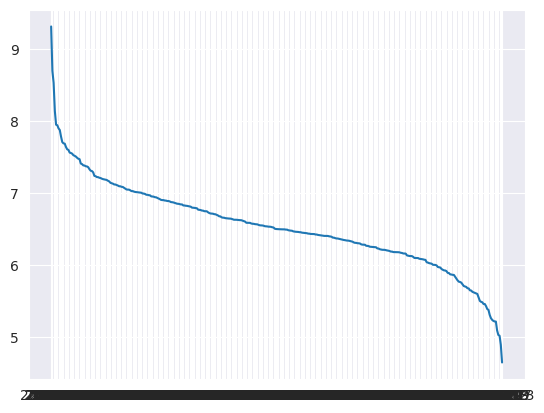

In [52]:
import matplotlib.pyplot as plt
plt.plot(sort_mean_popu_date['date'],sort_mean_popu_date['mean_popu'])
plt.show()

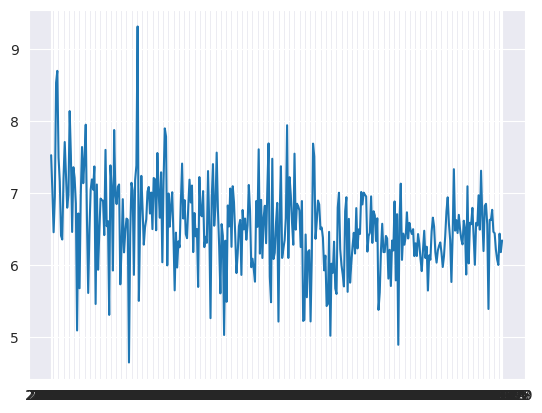

In [46]:
import matplotlib.pyplot as plt
plt.plot(reindexed_train_data_date['datetime'].unique(),all_mean_norm)
plt.show()

In [40]:
train_data_date['date'][0].day

28

In [31]:
 pd.to_datetime(1425139200,unit='ns')

Timestamp('1970-01-01 00:00:01.425139200')

In [34]:
from datetime import datetime
datetime.fromtimestamp(1425139200)

datetime.datetime(2015, 3, 1, 0, 0)